In [12]:
import pandas as pd
import json
import time
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import re
from openai import OpenAI

In [13]:
# 配置信息
CONFIG = {
    "base_url": "https://api.zhizengzeng.com/v1/",
    "api_key": "sk-zk20f741becece1c055c848225093b2e458662329a0f1016"
}

In [14]:
# 模型列表
MODELS = [
    "gpt-3.5-turbo",
    # "claude-sonnet-4-20250514", 
    # "gemini-2.5-flash",
    # "grok-3-mini",
    "deepseek-chat",
    # "qwen3-coder-plus"
]

In [ ]:
def get_prompt(sentence: str) -> str:
    """
    生成用于大模型的英文提示词
    """
    prompt = f"""
    **Background:** Ambiguity is the phenomenon that occurs when a sentence can be interpreted in more than one way. 
    It is defined as the ambiguity that leads to multiple interpretations by human readers, be it in the form of their disagreement on the interpretation or acknowledgment of multiple possible readings. 
    Having multiple interpretations might lead to misunderstanding the requirements, and thus cause significant implications on the success of the development process.
    
    Referential ambiguity (also called anaphora ambiguity) occurs when a pronoun is preceded by multiple antecedents. For example, in the following sentence, the pronoun "it" has three syntactically valid antecedents (in bold), although only the latter two are semantically valid:
    "The **procedure** shall convert the **24 bit image** to an **8 bit image**, then display **it** in a dynamic window."
    
    **Role:** You are a professional natural language processing expert specializing in handling referential ambiguity (anaphora ambiguity) in software requirements specifications.

    **Objectives:** Your task is to analyze the following sentence and complete the following tasks:
    
    1. Detect whether there is referential ambiguity in the sentence ("Detected as"):
       - If the pronoun in the sentence is ambiguous (i.e., there are multiple possible antecedents), mark it as "nocuous"
       - If the pronoun in the sentence is not ambiguous (there is only one clear antecedent), mark it as "innocuous"
    
    2. Perform anaphora resolution for the pronoun in the sentence ("Resolved as"):
       - If the sentence is marked as "nocuous", return "unknown"
       - If the sentence is marked as "innocuous", indicate the antecedent of the pronoun
       - If unable to determine, return "unknown"
    
    Sentence: {sentence}
    
    Please output your analysis result in the following JSON format:
    {{
        "Detected as": "...",
        "Resolved as": "..."
    }}
    
    Notes:
    - The value of "Detected as" can only be "nocuous" or "innocuous"
    - The value of "Resolved as" should be the specific content the pronoun refers to or "unknown"
    """
    return prompt

In [16]:
def call_llm(prompt: str, model: str) -> Dict:
    """
    调用大模型API使用OpenAI包
    """
    try:
        client = OpenAI(api_key=CONFIG["api_key"], base_url=CONFIG["base_url"])
        
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.1
        )
        
        content = response.choices[0].message.content
        
        # 尝试解析JSON格式的响应
        match = re.search(r'\{.*\}', content, re.DOTALL)
        if match:
            json_str = match.group()
            parsed_result = json.loads(json_str)
            return parsed_result
        else:
            # 如果无法解析JSON，返回默认值
            return {
                "Detected as": "nocuous",
                "Resolved as": "unknown"
            }
    except Exception as e:
        print(f"API call failed ({model}): {str(e)}")
        return {
            "Detected as": "nocuous",
            "Resolved as": "unknown"
        }

In [17]:
def evaluate_detection(y_true: List[str], y_pred: List[str]) -> Tuple[float, float]:
    """
    计算检测任务的精确率和召回率
    """
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for true_label, pred_label in zip(y_true, y_pred):
        # 统一转换为小写进行比较
        true_is_nocuous = true_label.lower() == "nocuous"
        pred_is_nocuous = pred_label.lower() == "nocuous"

        if true_is_nocuous and pred_is_nocuous:
            true_positives += 1
        elif not true_is_nocuous and pred_is_nocuous:
            false_positives += 1
        elif true_is_nocuous and not pred_is_nocuous:
            false_negatives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

In [18]:
def evaluate_resolution(true_labels: List[str], true_disambiguations: List[str], 
                      pred_labels: List[str], pred_disambiguations: List[str]) -> Tuple[float, float]:
    """
    计算消歧任务的精确率和召回率
    
    注意：Resolution任务只在以下条件下进行评估：
    1. 真实标签 = "nocuous"（有歧义）
    2. 预测标签 = "nocuous"（模型预测有歧义）
    3. 预测有实际的消歧结果（不是"unknown"）
    """
    correct_resolutions = 0
    attempted_resolutions = 0
    total_unambiguous = 0  # 真实有歧义的总数
    
    for i in range(len(true_labels)):
        true_label = true_labels[i].lower()
        pred_label = pred_labels[i].lower()
        
        # 处理NaN值并转换为字符串
        true_disambiguation = str(true_disambiguations[i]).lower() if not pd.isna(true_disambiguations[i]) else "unknown"
        pred_disambiguation = str(pred_disambiguations[i]).lower() if not pd.isna(pred_disambiguations[i]) else "unknown"

        # 统计真实有歧义的数量（标签为"nocuous"表示有歧义）
        if true_label == "nocuous":
            total_unambiguous += 1
        
        # 只在满足所有条件时才评估消歧：
        # 1. 真实标签为"innocuous"（无歧义）
        ## 2. 预测标签为"innocuous"（模型也预测无歧义）
        # 3. 真实标签有有效的消歧结果（不是nan/unknown）
        # 4. 预测标签有有效的消歧结果（不是unknown）
        if (
            # true_label == "innocuous" and 
            # pred_label == "innocuous" and 
            true_disambiguation not in ["nan", "unknown"] and
            pred_disambiguation != "unknown"
        ):
            
            attempted_resolutions += 1
            
            # 检查预测结果是否正确（支持部分匹配）
            # 完全匹配
            if true_disambiguation == pred_disambiguation:
                correct_resolutions += 1
            # 部分匹配：预测结果包含在真实结果中，或真实结果包含在预测结果中
            elif true_disambiguation in pred_disambiguation or pred_disambiguation in true_disambiguation:
                correct_resolutions += 1
    
    precision = correct_resolutions / attempted_resolutions if attempted_resolutions > 0 else 0
    recall = correct_resolutions / total_unambiguous if total_unambiguous > 0 else 0
    
    return precision, recall

In [19]:
def process_dataset(df: pd.DataFrame, model: str) -> Dict:
    """
    处理数据集并评估模型性能
    """
    results = {
        "model": model,
        "predictions": [],
        "metrics": {}
    }
    
    print(f"Processing model {model}...")
    
    for idx, row in df.iterrows():
        sentence = row['Sentence']
        true_detected = row['Detected as']
        true_disambiguated = row['Resolved as']
        
        prompt = get_prompt(sentence)
        prediction = call_llm(prompt, model)
        
        # 确保预测结果格式正确
        if "Detected as" not in prediction:
            prediction["Detected as"] = "nocuous"
        if "Resolved as" not in prediction:
            prediction["Resolved as"] = "unknown"
        
        results["predictions"].append({
            "id": row['ID'],
            "sentence": sentence,
            "true_detected": true_detected.lower(),
            "true_disambiguated": true_disambiguated,
            "pred_detected": prediction["Detected as"].lower(),
            "pred_disambiguated": prediction["Resolved as"]
        })
        
        # 添加进度信息
        if (idx + 1) % 10 == 0:
            print(f"  Processed {idx + 1}/{len(df)} samples")
    
    # 计算指标
    true_detected_list = [item["true_detected"] for item in results["predictions"]]
    pred_detected_list = [item["pred_detected"] for item in results["predictions"]]
    true_disambiguated_list = [item["true_disambiguated"] for item in results["predictions"]]
    pred_disambiguated_list = [item["pred_disambiguated"] for item in results["predictions"]]
    
    # 检测任务指标
    det_precision, det_recall = evaluate_detection(true_detected_list, pred_detected_list)
    det_f2 = (1 + 2*2) * det_precision * det_recall / (2*2 * det_precision + det_recall) if (2*2 * det_precision + det_recall) > 0 else 0
    
    # 消歧任务指标
    res_precision, res_recall = evaluate_resolution(
        true_detected_list, true_disambiguated_list,
        pred_detected_list, pred_disambiguated_list
    )
    res_f2 = (1 + 2*2) * res_precision * res_recall / (2*2 * res_precision + res_recall) if (2*2 * res_precision + res_recall) > 0 else 0
    
    results["metrics"] = {
        "detection": {
            "precision": det_precision,
            "recall": det_recall,
            "f2": det_f2
        },
        "resolution": {
            "precision": res_precision,
            "recall": res_recall,
            "f2": res_f2
        }
    }
    
    print(f"  Detection - Precision: {det_precision:.3f}, Recall: {det_recall:.3f}, F2: {det_f2:.3f}")
    print(f"  Resolution - Precision: {res_precision:.3f}, Recall: {res_recall:.3f}, F2: {res_f2:.3f}")
    
    return results

In [20]:
def create_visualization(results: List[Dict]):
    """
    创建可视化图表
    """
    models = [r["model"] for r in results]
    
    # 提取指标数据
    det_precisions = [r["metrics"]["detection"]["precision"] for r in results]
    det_recalls = [r["metrics"]["detection"]["recall"] for r in results]
    det_f2s = [r["metrics"]["detection"]["f2"] for r in results]
    
    res_precisions = [r["metrics"]["resolution"]["precision"] for r in results]
    res_recalls = [r["metrics"]["resolution"]["recall"] for r in results]
    res_f2s = [r["metrics"]["resolution"]["f2"] for r in results]
    
    # 创建图表
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    x = np.arange(len(models))
    width = 0.35
    
    # 检测任务精确率和召回率
    axes[0, 0].bar(x - width/2, det_precisions, width, label='Precision', alpha=0.8)
    axes[0, 0].bar(x + width/2, det_recalls, width, label='Recall', alpha=0.8)
    axes[0, 0].set_xlabel('Model')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Referential Ambiguity Detection Task - Precision & Recall')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 检测任务F2分数
    axes[0, 1].bar(models, det_f2s, alpha=0.8, color='skyblue')
    axes[0, 1].set_xlabel('Model')
    axes[0, 1].set_ylabel('F2 Score')
    axes[0, 1].set_title('Referential Ambiguity Detection Task - F2 Score')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 消歧任务精确率和召回率
    axes[1, 0].bar(x - width/2, res_precisions, width, label='Precision', alpha=0.8, color='lightgreen')
    axes[1, 0].bar(x + width/2, res_recalls, width, label='Recall', alpha=0.8, color='orange')
    axes[1, 0].set_xlabel('Model')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Anaphora Resolution Task - Precision & Recall')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # 消歧任务F2分数
    axes[1, 1].bar(models, res_f2s, alpha=0.8, color='lightcoral')
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('F2 Score')
    axes[1, 1].set_title('Anaphora Resolution Task - F2 Score')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('model_evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
def main():
    """
    主函数
    """
    print("Loading test dataset...")
    
    # 加载测试数据集
    df_test = pd.read_csv(r"data/frieden84-nlp4re-reqeval-3772a07/data/test.tsv", sep='\t', on_bad_lines='skip')
    
    all_results = []
    
    # 对每个模型进行评估
    for model in MODELS:
        result = process_dataset(df_test, model)
        all_results.append(result)
        
        # 添加延迟以避免API限制
        time.sleep(1)
    
    # 保存所有结果到JSON文件
    with open('evaluation_results.json', 'w', encoding='utf-8') as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2, default=str)
    
    print("\nAll model evaluations completed, results saved to evaluation_results.json")
    
    # 创建可视化图表
    create_visualization(all_results)
    
    # 打印详细结果
    print("\nDetailed evaluation results:")
    for result in all_results:
        model = result["model"]
        det_metrics = result["metrics"]["detection"]
        res_metrics = result["metrics"]["resolution"]
        
        print(f"\nModel: {model}")
        print(f"  Detection - Precision: {det_metrics['precision']:.3f}, Recall: {det_metrics['recall']:.3f}, F2: {det_metrics['f2']:.3f}")
        print(f"  Resolution - Precision: {res_metrics['precision']:.3f}, Recall: {res_metrics['recall']:.3f}, F2: {res_metrics['f2']:.3f}")


Loading test dataset...
Processing model gpt-3.5-turbo...
  Processed 10/72 samples
  Processed 20/72 samples
  Processed 30/72 samples
  Processed 40/72 samples
  Processed 50/72 samples
  Processed 60/72 samples
API call failed (gpt-3.5-turbo): Connection error.
  Processed 70/72 samples
  Detection - Precision: 0.582, Recall: 0.951, F2: 0.844
  Resolution - Precision: 0.538, Recall: 0.341, F2: 0.368
Processing model deepseek-chat...
  Processed 10/72 samples
  Processed 20/72 samples
  Processed 30/72 samples
  Processed 40/72 samples
  Processed 50/72 samples
API call failed (deepseek-chat): Connection error.
API call failed (deepseek-chat): Connection error.
API call failed (deepseek-chat): Connection error.
API call failed (deepseek-chat): Connection error.
API call failed (deepseek-chat): Connection error.
  Processed 60/72 samples
  Processed 70/72 samples
  Detection - Precision: 0.647, Recall: 0.805, F2: 0.767
  Resolution - Precision: 0.793, Recall: 0.561, F2: 0.596

All mod

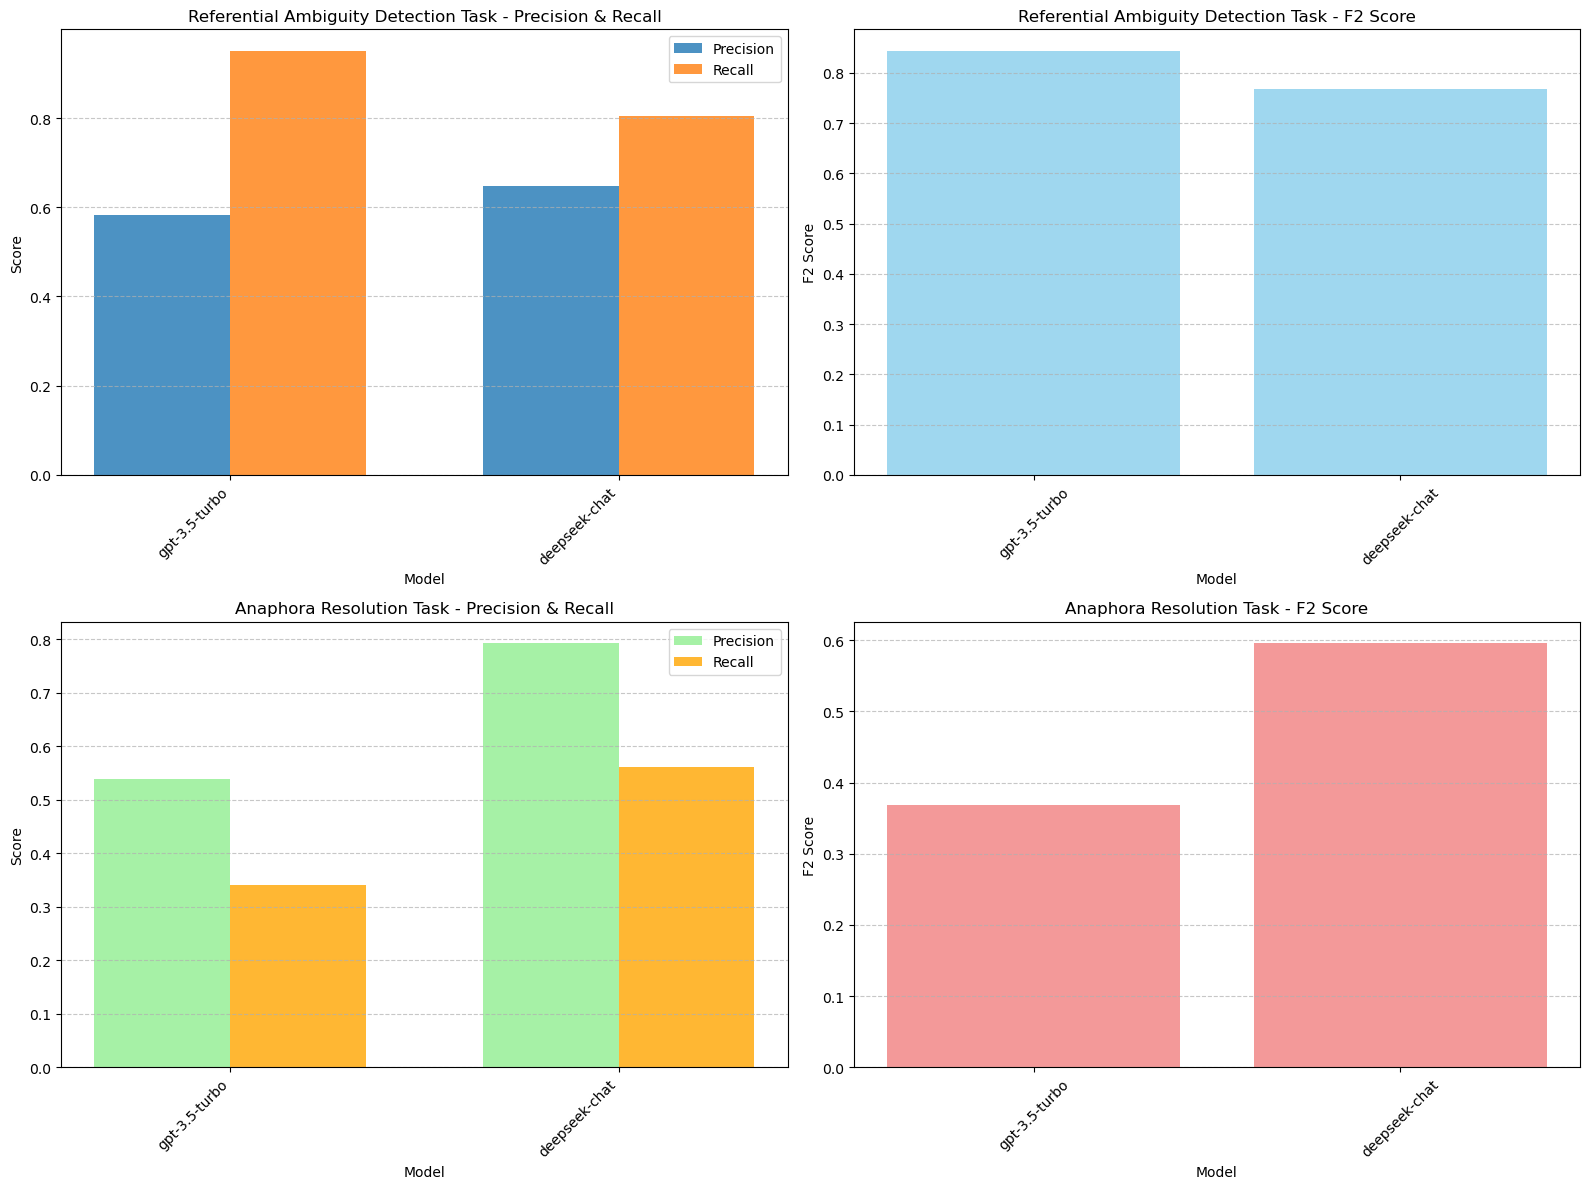


Detailed evaluation results:

Model: gpt-3.5-turbo
  Detection - Precision: 0.582, Recall: 0.951, F2: 0.844
  Resolution - Precision: 0.538, Recall: 0.341, F2: 0.368

Model: deepseek-chat
  Detection - Precision: 0.647, Recall: 0.805, F2: 0.767
  Resolution - Precision: 0.793, Recall: 0.561, F2: 0.596


In [22]:
main()